# Chapter 11

In [ ]:
library(MASS)

## be careful to load dplyr after MASS
library(dplyr)
library(tidyr)
library(purrr)
library(extraDistr)
library(ggplot2)
library(loo)
library(bridgesampling)
library(brms)
library(bayesplot)
library(tictoc)
library(hypr)
library(bcogsci)
library(lme4)
library(rstan)
# library(cmdstanr)
library(rootSolve)

In [2]:
## Save compiled models:
rstan_options(auto_write = FALSE)
## Parallelize the chains using all the cores:
options(mc.cores = parallel::detectCores())
# To solve some conflicts between packages
select <- dplyr::select
extract <- rstan::extract

In [3]:
data("df_eeg")

## Varying intercept model with Stan

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n]} + c\_cloze_n \cdot \beta,\sigma)
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha &\sim \mathit{Normal}(0,10)\\
\beta  &\sim \mathit{Normal}(0,10)\\
u &\sim \mathit{Normal}(0,\tau_u)\\
\tau_{u} &\sim \mathit{Normal}_+(0,20) \\
\sigma  &\sim \mathit{Normal}_+(0,50)
\end{aligned}
\end{equation}
$$

In [4]:
# center load variable
df_eeg <- df_eeg %>%
  mutate(c_cloze = cloze - mean(cloze))

In [5]:
# define data for Stan model
ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  N_subj = max(df_eeg$subj)
)

In [9]:
# fit model
fit_n400_1 <- stan("stan_models/n400_hierarchical.stan", data = ls_eeg)

Warning message in FUN(X[[i]], ...):
"tekst niereprezentowalny w natywnym kodowaniu bedzie przetlumaczony na UTF-8"


In [11]:
print(fit_n400_1, pars = c("alpha", "beta", "sigma", "tau_u"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  3.62    0.01 0.43  2.81  3.33  3.63  3.90  4.47  1643    1
beta   2.31    0.01 0.54  1.24  1.95  2.32  2.66  3.39  5324    1
sigma 11.64    0.00 0.15 11.35 11.53 11.63 11.74 11.94  4754    1
tau_u  2.18    0.01 0.37  1.55  1.92  2.16  2.41  3.00  2247    1

Samples were drawn using NUTS(diag_e) at Sat Sep 10 13:23:49 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



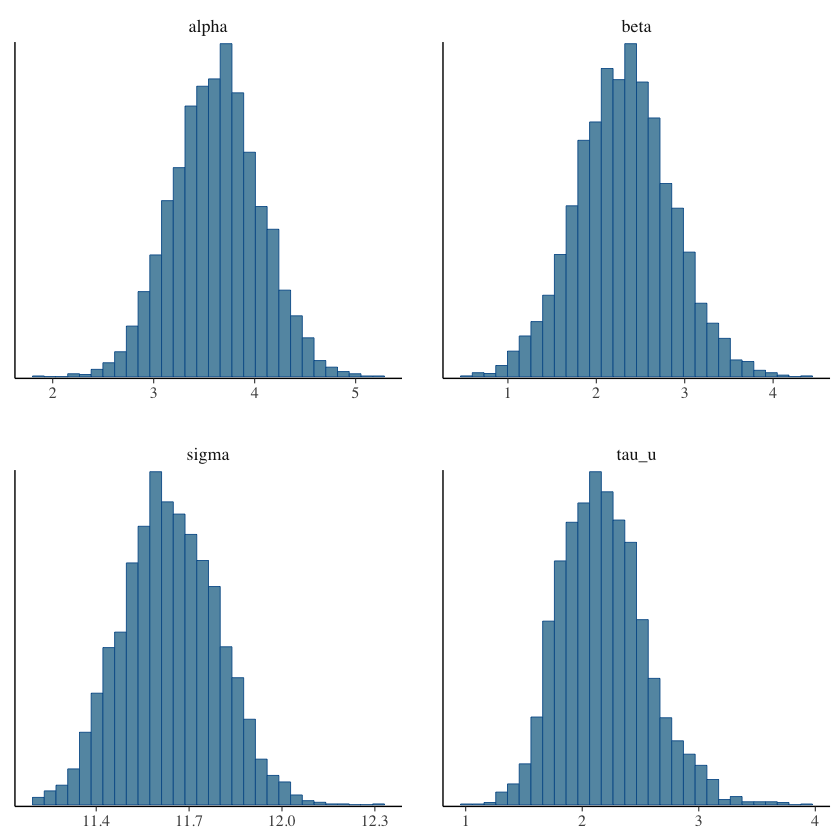

In [12]:
# cast to df
df_fit_n400_1 <- as.data.frame(fit_n400_1)

mcmc_hist(df_fit_n400_1[1:4])

## Uncorrelated varying intercept and slopes model with Stan

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + c\_cloze_n \cdot (\beta+ u_{subj[n],2}),\sigma)
\tag{11.1}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha &\sim \mathit{Normal}(0,10)\\
\beta  &\sim \mathit{Normal}(0,10)\\
u_1 &\sim \mathit{Normal}(0,\tau_{u_1})\\
u_2 &\sim \mathit{Normal}(0,\tau_{u_2})\\
\tau_{u_1} &\sim \mathit{Normal}_+(0,20) \\
\tau_{u_2} &\sim \mathit{Normal}_+(0,20) \\
\sigma  &\sim \mathit{Normal}_+(0,50)
\end{aligned}
\tag{11.2}
\end{equation}
$$

In [6]:
# define data for Stan model

ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  N_subj = max(df_eeg$subj)
)

In [7]:
# fit model
fit_n400_2 <- stan("stan_models/n400_hierarchical_uncorr.stan", data = ls_eeg)

Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


In [8]:
print(fit_n400_2, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha     3.64    0.01 0.41  2.79  3.36  3.64  3.92  4.42  1352 1.00
beta      2.33    0.01 0.61  1.16  1.92  2.32  2.72  3.53  3298 1.00
tau_u[1]  2.17    0.01 0.37  1.54  1.91  2.13  2.39  3.01  2266 1.00
tau_u[2]  1.61    0.10 0.92  0.19  0.80  1.60  2.26  3.48    91 1.03
sigma    11.62    0.00 0.15 11.32 11.52 11.62 11.72 11.93  5247 1.00

Samples were drawn using NUTS(diag_e) at Tue Sep 13 10:42:04 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Non-center parametrisation

In [9]:
# fit model
fit_n400_uncentered <- stan("stan_models/n400_hierarchical_uncorr_nc.stan", data = ls_eeg)

In [10]:
print(fit_n400_uncentered, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha     3.64    0.01 0.44  2.76  3.36  3.65  3.93  4.49  1475    1
beta      2.32    0.01 0.62  1.12  1.90  2.33  2.73  3.49  4156    1
tau_u[1]  2.20    0.01 0.37  1.52  1.94  2.17  2.42  3.01  1743    1
tau_u[2]  1.73    0.03 0.93  0.11  1.03  1.75  2.39  3.52   888    1
sigma    11.62    0.00 0.16 11.32 11.51 11.62 11.72 11.94  6898    1

Samples were drawn using NUTS(diag_e) at Tue Sep 13 10:44:55 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Correlated varying intercept varying slopes model

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n],1} + c\_cloze_n \cdot  (\beta + u_{subj[n],2}),\sigma)
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha & \sim \mathit{Normal}(0,10) \\
\beta  & \sim \mathit{Normal}(0,10) \\
  \sigma  &\sim \mathit{Normal}_+(0,50)\\
  {\begin{pmatrix}
  u_{i,1} \\
  u_{i,2}
  \end{pmatrix}}
&\sim {\mathcal {N}}
  \left(
{\begin{pmatrix}
  0\\
  0
\end{pmatrix}}
,\boldsymbol{\Sigma_u} \right)
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\boldsymbol{\Sigma_u} =
{\begin{pmatrix}
\tau_{u_1}^2 & \rho_u \tau_{u_1} \tau_{u_2} \\
\rho_u \tau_{u_1} \tau_{u_2} & \tau_{u_2}^2
\end{pmatrix}}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\tau_{u_1} &\sim \mathit{Normal}_+(0,20)\\
\tau_{u_2} &\sim \mathit{Normal}_+(0,20)\\
\rho_u &\sim \mathit{LKJcorr}(2)
\end{aligned}
\end{equation}
$$

In [ ]:
# fit model
fit_n400_corr <- stan("stan_models/n400_hierarchical_corr_IS.stan", data = ls_eeg)

Again, we have bad mixing of the chains for tau_u[2].

The problem (which can also be discovered in a pairs plot) is the same one that we saw before: There is a strong correlation between tau_u[2] (in fact, log(tau_u[2]), which is the parameter dimension that the sampler considers) and u, creating a funnel.

In [23]:
print(fit_n400_corr, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha     3.64    0.01 0.42  2.79  3.37  3.63  3.92  4.48  1107 1.00
beta      2.33    0.01 0.61  1.12  1.91  2.33  2.75  3.53  3820 1.00
tau_u[1]  2.20    0.01 0.38  1.54  1.93  2.16  2.42  3.05  2437 1.00
tau_u[2]  1.66    0.10 0.89  0.09  1.01  1.63  2.25  3.50    80 1.05
sigma    11.62    0.00 0.16 11.32 11.51 11.62 11.72 11.94  6132 1.00

Samples were drawn using NUTS(diag_e) at Sat Sep 10 14:09:13 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


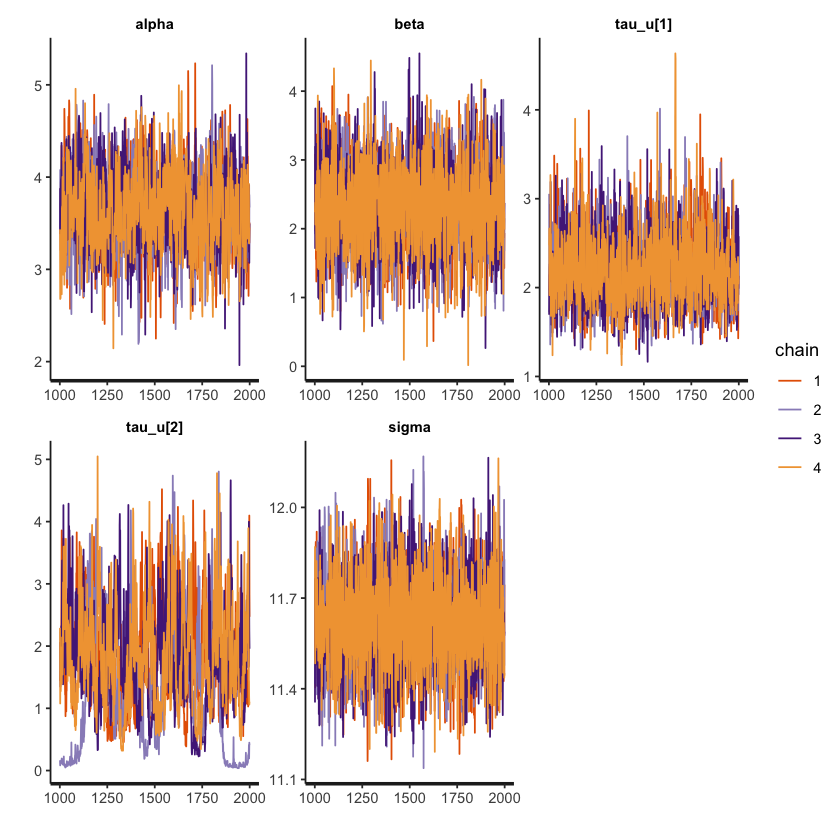

In [25]:
traceplot(fit_n400_corr, pars = c("alpha", "beta", "tau_u", "sigma"))

### Non-centered parametrisation

In [ ]:
# fit model
fit_n400_corr_uc <- stan("stan_models/n400_hierarchical_corr_IS_uc.stan", data = ls_eeg)

Again, we have bad mixing of the chains for tau_u[2].

The problem (which can also be discovered in a pairs plot) is the same one that we saw before: There is a strong correlation between tau_u[2] (in fact, log(tau_u[2]), which is the parameter dimension that the sampler considers) and u, creating a funnel.

In [ ]:
print(fit_n400_corr_uc, pars = c("alpha", "beta", "tau_u", "sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha     3.64    0.01 0.42  2.79  3.37  3.63  3.92  4.48  1107 1.00
beta      2.33    0.01 0.61  1.12  1.91  2.33  2.75  3.53  3820 1.00
tau_u[1]  2.20    0.01 0.38  1.54  1.93  2.16  2.42  3.05  2437 1.00
tau_u[2]  1.66    0.10 0.89  0.09  1.01  1.63  2.25  3.50    80 1.05
sigma    11.62    0.00 0.16 11.32 11.51 11.62 11.72 11.94  6132 1.00

Samples were drawn using NUTS(diag_e) at Sat Sep 10 14:09:13 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## By-subject and by-items correlated varying intercept varying slopes model

$$
\begin{equation}
  signal_n \sim \mathit{Normal}(\alpha + u_{subj[n], 1} + w_{item[n], 1} +
  c\_cloze_n \cdot  (\beta + u_{subj[n],2} + w_{item[n], 2}),\sigma)
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\alpha & \sim \mathit{Normal}(0,10) \\
\beta  & \sim \mathit{Normal}(0,10) \\
  \sigma  &\sim \mathit{Normal}_+(0, 50)\\
    {\begin{pmatrix}
  u_{i,1} \\
  u_{i,2}
  \end{pmatrix}}
&\sim {\mathcal {N}}
  \left(
{\begin{pmatrix}
  0\\
  0
\end{pmatrix}}
,\boldsymbol{\Sigma_u} \right) \\
   {\begin{pmatrix}
  w_{i,1} \\
  w_{i,2}
  \end{pmatrix}}
&\sim {\mathcal {N}}
  \left(
{\begin{pmatrix}
  0\\
  0
\end{pmatrix}}
,\boldsymbol{\Sigma_w} \right)
\end{aligned}
\end{equation}
$$

In [26]:
# center variable item
df_eeg <- df_eeg %>%
  mutate(item = as.numeric(as.factor(item)))

In [27]:
# create data for Stan model
ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  item = df_eeg$item,
  N_subj = max(df_eeg$subj),
  N_item = max(df_eeg$item))

In [28]:
fit_eeg_sub_item_uc <- stan("stan_models/n400_hierarchical_corr_IS_item_uc.stan", data = ls_eeg)

In [29]:
print(fit_eeg_sub_item_uc,
  pars = c("alpha", "beta", "sigma", "tau_u", "tau_w", "rho_u", "rho_w"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha       3.67    0.01 0.46  2.77  3.36  3.66  3.97  4.59  2228    1
beta        2.31    0.01 0.68  0.93  1.86  2.32  2.77  3.61  5073    1
sigma      11.49    0.00 0.16 11.18 11.38 11.48 11.59 11.82  5564    1
tau_u[1]    2.21    0.01 0.38  1.55  1.94  2.18  2.44  3.05  1924    1
tau_u[2]    1.51    0.03 0.90  0.09  0.77  1.46  2.13  3.38  1185    1
tau_w[1]    1.50    0.01 0.35  0.79  1.27  1.51  1.73  2.17  1181    1
tau_w[2]    2.31    0.03 1.03  0.28  1.60  2.33  3.02  4.30  1138    1
rho_u[1,1]  1.00     NaN 0.00  1.00  1.00  1.00  1.00  1.00   NaN  NaN
rho_u[1,2]  0.13    0.01 0.36 -0.64 -0.12  0.15  0.39  0.78  4875    1
rho_u[2,1]  0.13    0.01 0.36 -0.64 -0.12  0.15  0.39  0.78  4875    1
rho_u[2,2]  1.00    0.00 0.00  1.00  1.00  1.00  1.00  1.00  36

In [36]:
mcmc_hist(as.data.frame(fit_eeg_sub_item_uc),
  pars = c("alpha", "beta", "sigma", "rho_u[1,2]", "rho_w[1,2]")
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



ERROR: Error in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : nie znaleziono krawedzi wielokata


plot without title

In [42]:
head(as.data.frame(fit_eeg_sub_item_uc))

,sigma,tau_u[1],tau_u[2],tau_w[1],tau_w[2],alpha,beta,"z_u[1,1]","z_u[2,1]","z_u[1,2]",⋯,"w[80,2]","rho_u[1,1]","rho_u[2,1]","rho_u[1,2]","rho_u[2,2]","rho_w[1,1]","rho_w[2,1]","rho_w[1,2]","rho_w[2,2]",lp__
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11.42731,2.648775,3.101743,1.575959,2.7315546,3.070930,2.141262,1.03990832,-0.948204269,-0.07979825,⋯,4.2744532,1,0.49598054,0.49598054,1,1,-0.4798683,-0.4798683,1,-11389.71
2,11.45966,2.290508,3.464274,1.722849,3.1564316,2.968029,1.150138,0.47226553,0.006446571,-0.46196870,⋯,-0.6813576,1,0.27583481,0.27583481,1,1,-0.4628359,-0.4628359,1,-11378.87
3,11.64481,2.644096,2.541806,1.832041,2.1971694,4.144196,3.321549,0.63562174,-0.265522937,-0.86718235,⋯,2.0644900,1,0.20651873,0.20651873,1,1,-0.6759470,-0.6759470,1,-11387.59
4,11.73948,1.496344,3.122183,1.485042,0.9431758,3.938580,2.352040,0.03660147,-0.201122636,-0.45306926,⋯,-0.4477828,1,0.31927400,0.31927400,1,1,-0.7620738,-0.7620738,1,-11391.62
5,11.24263,2.394510,2.488947,1.414651,1.3596088,3.872498,2.368005,0.59905191,-1.065696401,-0.43894187,⋯,0.6216572,1,-0.05672271,-0.05672271,1,1,-0.7492056,-0.7492056,1,-11378.56
6,11.61640,2.011437,1.735267,1.846907,2.4284406,3.682473,1.642966,-0.06269764,0.123591061,-0.69857262,⋯,-0.2807283,1,0.28861067,0.28861067,1,1,-0.4350421,-0.4350421,1,-11391.64


#### Adjustment to the slope (beta)

In [64]:
# make a table of u_2s
ind_effects_v <- paste0("u[", unique(df_eeg$subj), 
                        ",2]")
ind_effects_v

[1] "u[1,2]"  "u[2,2]"  "u[3,2]"  "u[4,2]"  "u[5,2]"  "u[6,2]"  "u[7,2]" 
 [8] "u[8,2]"  "u[9,2]"  "u[10,2]" "u[11,2]" "u[12,2]" "u[13,2]" "u[14,2]"
[15] "u[15,2]" "u[16,2]" "u[17,2]" "u[18,2]" "u[19,2]" "u[20,2]" "u[21,2]"
[22] "u[22,2]" "u[23,2]" "u[24,2]" "u[25,2]" "u[26,2]" "u[27,2]" "u[28,2]"
[29] "u[29,2]" "u[30,2]" "u[31,2]" "u[32,2]" "u[33,2]" "u[34,2]" "u[35,2]"
[36] "u[36,2]" "u[37,2]"

In [66]:
adjustment <- as.data.frame(fit_eeg_sub_item_uc)[ind_effects_v]
beta <- as.data.frame(fit_eeg_sub_item_uc)$beta
by_subj_effect <- as.data.frame(beta + adjustment)

In [82]:
par_h <- lapply(by_subj_effect, function(x) {
  tibble(
    Estimate = mean(x),
    Q2.5 = quantile(x, .025),
    Q97.5 = quantile(x, .975)
  )
}) %>%
  bind_rows() %>%
  # Add a column to identify that the model,
  # and one with the subject labels:
  mutate(
    model = "Hierarchical",
    subj = unique(df_eeg$subj)
  ) %>%
  arrange(Estimate) %>%
  mutate(subj = factor(subj, levels = unique(.data$subj)))

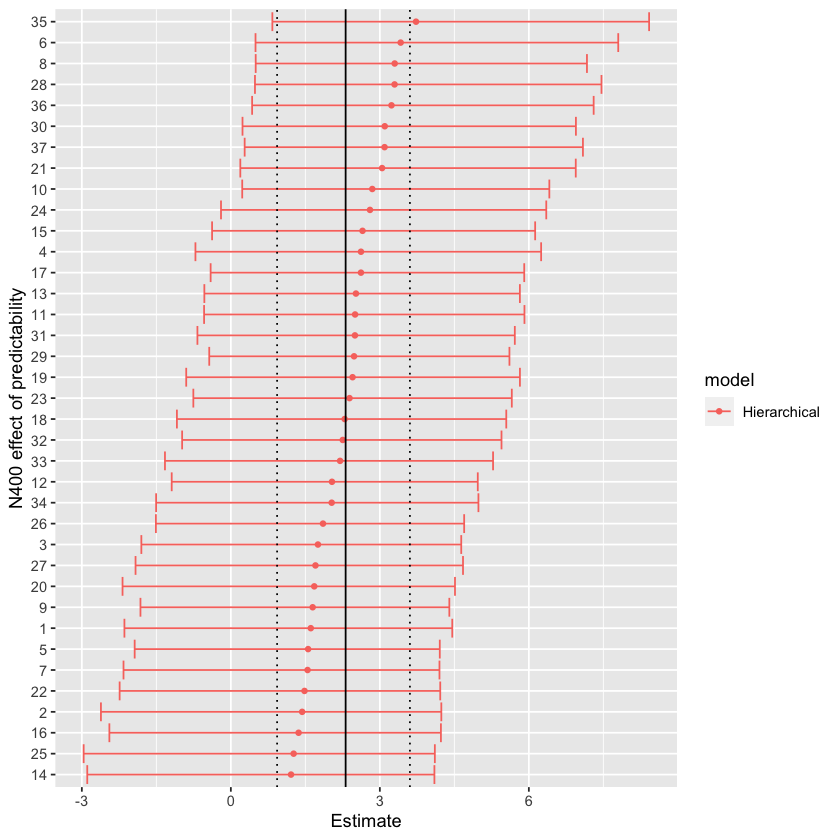

In [88]:
ggplot(
  par_h,
  aes(
    ymin = Q2.5, ymax = Q97.5, x = subj, y = Estimate, color = model,
    shape = model
  )
) +
  geom_errorbar(position = position_dodge(1)) +
  geom_point(position = position_dodge(1)) +
  # We'll also add the mean and 95% CrI of the overall difference
  # to the plot:
  geom_hline(
    yintercept =
      mean(beta)
  ) +
  geom_hline(
    yintercept =
      quantile(beta, .025),
    linetype = "dotted", size = .5
  ) +
  geom_hline(
    yintercept =
      quantile(beta, .975),
    linetype = "dotted", size = .5
  ) +
  xlab("N400 effect of predictability") +
  coord_flip()

# Excercises

## 11.1

### Log-normal model in Stan

Refit the Stroop example from section 5.3 in Stan (df_stroop).

In [ ]:
data("df_stroop")
(df_stroop <- df_stroop %>%
  mutate(c_cond = if_else(condition == "Incongruent", 1, -1)))

In [13]:
head(df_stroop)

subj,trial,condition,RT,c_cond
<dbl>,<int>,<chr>,<int>,<dbl>
1,0,Congruent,1484,-1
1,1,Incongruent,1316,1
1,2,Incongruent,628,1
1,3,Congruent,511,-1
1,4,Congruent,509,-1
1,5,Incongruent,903,1


In [14]:
# define data for Stan model

ls_stroop <- list(
  N = nrow(df_stroop),
  rt = df_stroop$RT,
  c_cond = df_stroop$c_cond,
  subj = df_stroop$subj,
  N_subj = max(df_stroop$subj)
)

In [15]:
# fit model
fit_stroop_corr <- stan("stan_models/stroop_corr.stan", data = ls_stroop)

Warning message:
"There were 19 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


In [17]:
print(fit_stroop_corr,
  pars = c("alpha", "beta", "sigma", "tau_u", "rho_u"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd  2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha      6.33    0.00 0.02  6.30 6.32 6.33 6.34  6.36   448 1.01
beta       0.04    0.00 0.01  0.02 0.03 0.04 0.04  0.05  2819 1.00
sigma      0.28    0.00 0.00  0.27 0.28 0.28 0.28  0.29  5206 1.00
tau_u[1]   0.12    0.00 0.01  0.09 0.11 0.11 0.12  0.15  3325 1.00
tau_u[2]   0.02    0.00 0.01  0.01 0.02 0.02 0.03  0.04   184 1.03
rho_u[1,1] 1.00     NaN 0.00  1.00 1.00 1.00 1.00  1.00   NaN  NaN
rho_u[1,2] 0.51    0.01 0.24 -0.02 0.35 0.54 0.69  0.91   371 1.01
rho_u[2,1] 0.51    0.01 0.24 -0.02 0.35 0.54 0.69  0.91   371 1.01
rho_u[2,2] 1.00    0.00 0.00  1.00 1.00 1.00 1.00  1.00  3697 1.00

Samples were drawn using NUTS(diag_e) at Tue Sep 13 10:57:59 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale red

### Non-centered

In [21]:
# fit model
fit_stroop_corr_uc <- stan("stan_models/stroop_corr_uc.stan", data = ls_stroop)

In [23]:
print(fit_stroop_corr_uc,
  pars = c("alpha", "beta", "sigma", "tau_u", "rho_u"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd  2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha      6.33       0 0.02  6.29 6.32 6.33 6.34  6.36   684    1
beta       0.04       0 0.01  0.03 0.03 0.04 0.04  0.05  4253    1
sigma      0.28       0 0.00  0.27 0.28 0.28 0.28  0.29  6163    1
tau_u[1]   0.12       0 0.01  0.09 0.11 0.11 0.12  0.15   973    1
tau_u[2]   0.02       0 0.01  0.00 0.01 0.02 0.03  0.04  1078    1
rho_u[1,1] 1.00     NaN 0.00  1.00 1.00 1.00 1.00  1.00   NaN  NaN
rho_u[1,2] 0.49       0 0.26 -0.08 0.33 0.52 0.68  0.90  2805    1
rho_u[2,1] 0.49       0 0.26 -0.08 0.33 0.52 0.68  0.90  2805    1
rho_u[2,2] 1.00       0 0.00  1.00 1.00 1.00 1.00  1.00  3813    1

Samples were drawn using NUTS(diag_e) at Tue Sep 13 11:21:33 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale red

In [51]:
mean(exp(as.data.frame(fit_stroop_corr_uc)$alpha))

[1] 561.1095

In [24]:
alpha_samples <- as_draws_df(fit_stroop_corr_uc)$alpha 
beta_samples <- as_draws_df(fit_stroop_corr_uc)$beta

median_effect_rt <- 
    exp(alpha_samples + beta_samples) - exp(alpha_samples - beta_samples)
    
stats = c(mean_median_effect = mean(median_effect_rt),
quantile(median_effect_rt, c(0.025, 0.975)))
            
print(stats)

mean_median_effect               2.5%              97.5% 
          42.16131           28.37552           56.17312 


#### Adjustment to the slope  by subject

In [52]:
# make a table of u_2s
ind_effects_v <- paste0("u[", unique(df_stroop$subj), 
                        ",2]")
ind_effects_v

[1] "u[1,2]"  "u[11,2]" "u[15,2]" "u[18,2]" "u[19,2]" "u[24,2]" "u[36,2]"
 [8] "u[38,2]" "u[45,2]" "u[48,2]" "u[2,2]"  "u[3,2]"  "u[4,2]"  "u[5,2]" 
[15] "u[6,2]"  "u[7,2]"  "u[8,2]"  "u[9,2]"  "u[10,2]" "u[12,2]" "u[13,2]"
[22] "u[14,2]" "u[16,2]" "u[17,2]" "u[20,2]" "u[21,2]" "u[22,2]" "u[23,2]"
[29] "u[25,2]" "u[26,2]" "u[27,2]" "u[28,2]" "u[29,2]" "u[30,2]" "u[31,2]"
[36] "u[32,2]" "u[33,2]" "u[34,2]" "u[35,2]" "u[37,2]" "u[39,2]" "u[40,2]"
[43] "u[41,2]" "u[42,2]" "u[43,2]" "u[44,2]" "u[46,2]" "u[47,2]" "u[49,2]"
[50] "u[50,2]"

In [53]:
adjustment <- as.data.frame(fit_stroop_corr_uc)[ind_effects_v]
beta <- as.data.frame(fit_stroop_corr_uc)$beta
alpha <- as.data.frame(fit_stroop_corr_uc)$alpha
by_subj_effect <- as.data.frame(exp(alpha + beta + adjustment) - exp(alpha - beta - adjustment))

In [54]:
head(by_subj_effect)

,"u[1,2]","u[11,2]","u[15,2]","u[18,2]","u[19,2]","u[24,2]","u[36,2]","u[38,2]","u[45,2]","u[48,2]",⋯,"u[39,2]","u[40,2]","u[41,2]","u[42,2]","u[43,2]","u[44,2]","u[46,2]","u[47,2]","u[49,2]","u[50,2]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,85.42045,25.532256,43.320878,71.05648,33.98324,79.49616,52.15197,23.93912,26.595039,74.79256,⋯,42.57564,105.53897,42.92949,27.17868,41.004464,54.87144,26.920653,59.28161,16.903964,39.18012
2,52.00593,19.956654,-14.751866,59.20178,52.54677,12.06125,15.18303,83.05401,63.804207,74.90350,⋯,54.50763,117.37456,58.16590,43.21155,3.527513,27.84103,50.122259,57.94620,53.824409,-14.30373
3,71.47314,20.810022,28.455707,99.89001,32.41441,66.53934,55.17282,30.30603,9.535164,71.25740,⋯,104.68303,49.97722,50.87217,-11.84916,29.751569,32.37862,5.539541,44.72747,20.968209,26.88690
4,63.20646,8.279911,47.155705,58.54414,30.61237,45.61022,14.57495,13.97933,53.679979,61.72390,⋯,30.48199,151.01191,26.42165,34.25502,17.558038,53.96526,57.203198,60.49404,4.980516,14.41178
5,96.24611,22.748918,-1.497814,40.98264,60.82027,57.58785,25.65135,34.53101,3.852209,50.81915,⋯,90.97870,47.15546,40.96602,39.46646,56.149171,43.41476,-2.567702,39.47671,43.946653,58.00786
6,82.05409,8.874209,32.972854,68.63836,60.59401,45.31358,42.13655,27.99350,45.672541,49.00699,⋯,24.74285,117.78091,29.05916,26.37650,37.377747,48.19973,32.288651,47.95170,1.632485,17.22695


In [55]:
par_h <- lapply(by_subj_effect, function(x) {
  tibble(
    Estimate = mean(x),
    Q2.5 = quantile(x, .025),
    Q97.5 = quantile(x, .975)
  )
}) %>%
  bind_rows() %>%
  # Add a column to identify that the model,
  # and one with the subject labels:
  mutate(
    model = "Hierarchical",
    subj = unique(df_stroop$subj)
  ) %>%
  arrange(Estimate) %>%
  mutate(subj = factor(subj, levels = unique(.data$subj)))

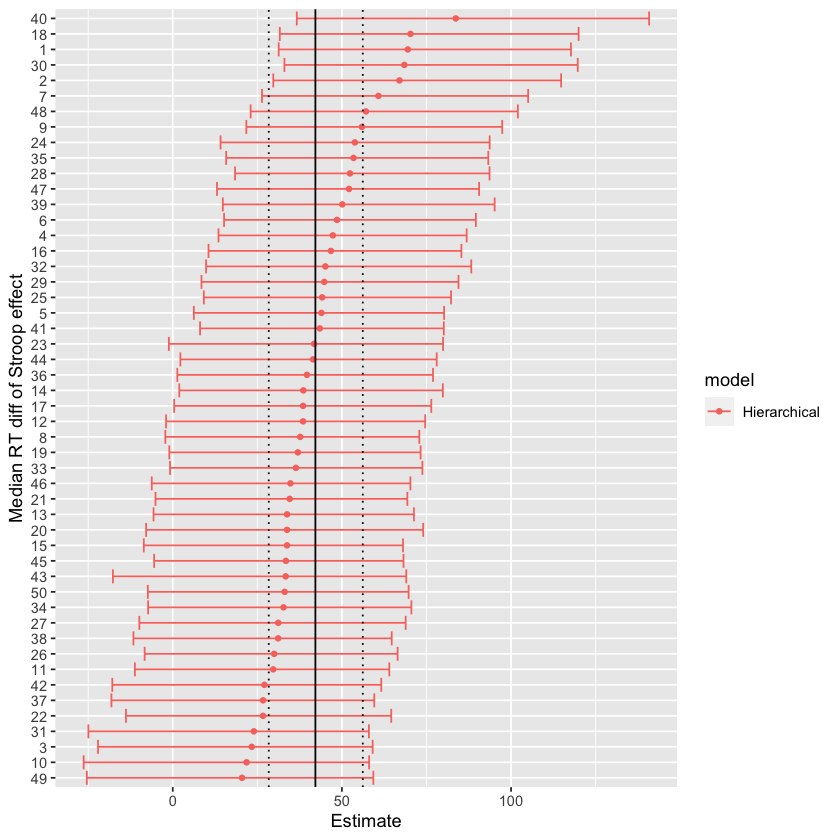

In [56]:
ggplot(
  par_h,
  aes(
    ymin = Q2.5, ymax = Q97.5, x = subj, y = Estimate, color = model,
    shape = model
  )
) +
  geom_errorbar(position = position_dodge(1)) +
  geom_point(position = position_dodge(1)) +
  # We'll also add the mean and 95% CrI of the overall difference
  # to the plot:
  geom_hline(
    yintercept =
      mean(median_effect_rt)
  ) +
  geom_hline(
    yintercept =
      quantile(median_effect_rt, .025),
    linetype = "dotted", size = .5
  ) +
  geom_hline(
    yintercept =
      quantile(median_effect_rt, .975),
    linetype = "dotted", size = .5
  ) +
  xlab("Median RT diff of Stroop effect") +
  coord_flip()

#### Adjustment to the intercept by subject

In [57]:
# make a table of u_1s
ind_effects_v_1 <- paste0("u[", unique(df_stroop$subj), 
                        ",1]")
ind_effects_v_1

[1] "u[1,1]"  "u[11,1]" "u[15,1]" "u[18,1]" "u[19,1]" "u[24,1]" "u[36,1]"
 [8] "u[38,1]" "u[45,1]" "u[48,1]" "u[2,1]"  "u[3,1]"  "u[4,1]"  "u[5,1]" 
[15] "u[6,1]"  "u[7,1]"  "u[8,1]"  "u[9,1]"  "u[10,1]" "u[12,1]" "u[13,1]"
[22] "u[14,1]" "u[16,1]" "u[17,1]" "u[20,1]" "u[21,1]" "u[22,1]" "u[23,1]"
[29] "u[25,1]" "u[26,1]" "u[27,1]" "u[28,1]" "u[29,1]" "u[30,1]" "u[31,1]"
[36] "u[32,1]" "u[33,1]" "u[34,1]" "u[35,1]" "u[37,1]" "u[39,1]" "u[40,1]"
[43] "u[41,1]" "u[42,1]" "u[43,1]" "u[44,1]" "u[46,1]" "u[47,1]" "u[49,1]"
[50] "u[50,1]"

In [58]:
adjustment_intercept <- as.data.frame(fit_stroop_corr_uc)[ind_effects_v_1]
# beta <- as.data.frame(fit_stroop_corr_uc)$beta
alpha <- as.data.frame(fit_stroop_corr_uc)$alpha
by_subj_effect_intercept <- as.data.frame(exp(alpha + adjustment_intercept))

In [59]:
head(by_subj_effect_intercept)

,"u[1,1]","u[11,1]","u[15,1]","u[18,1]","u[19,1]","u[24,1]","u[36,1]","u[38,1]","u[45,1]","u[48,1]",⋯,"u[39,1]","u[40,1]","u[41,1]","u[42,1]","u[43,1]","u[44,1]","u[46,1]","u[47,1]","u[49,1]","u[50,1]"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,694.0750,523.8993,545.6555,655.3575,558.9146,688.0976,574.3207,557.2402,543.4396,621.1689,⋯,529.5658,806.7900,559.5721,509.9803,619.1394,543.5454,518.5034,661.0286,497.0175,516.4514
2,691.3771,521.5476,577.8285,739.6282,497.0515,635.6303,540.5478,503.8840,523.5068,570.3598,⋯,521.9168,774.8300,548.3429,482.3761,651.7779,550.5041,566.7897,628.5487,421.1319,547.1653
3,702.5727,546.1944,532.2942,650.1725,582.8832,688.8387,523.9347,530.4022,521.7858,592.5021,⋯,544.3947,800.2124,548.8631,531.7851,613.7240,562.2410,516.1621,660.3438,474.7968,495.2496
4,706.4713,501.8092,560.1286,728.0026,508.6637,642.9982,580.7461,559.5340,551.5761,600.5628,⋯,494.6335,821.6209,583.2026,517.9803,650.6633,566.6590,585.4093,640.3976,443.7606,540.2080
5,685.9741,552.9264,555.1122,724.7871,565.1498,707.2752,556.5443,564.9220,517.8575,597.5815,⋯,569.1180,791.8904,575.2087,513.4968,633.7613,520.8150,521.7718,682.1780,471.1299,519.1244
6,696.7484,520.8104,559.5695,702.5097,533.8189,649.0085,544.4014,541.2173,556.0307,634.3370,⋯,502.4331,823.4778,542.4798,496.4924,621.9573,560.5908,553.0048,624.7873,462.3757,507.2890


In [60]:
par_h <- lapply(by_subj_effect_intercept, function(x) {
  tibble(
    Estimate = mean(x),
    Q2.5 = quantile(x, .025),
    Q97.5 = quantile(x, .975)
  )
}) %>%
  bind_rows() %>%
  # Add a column to identify that the model,
  # and one with the subject labels:
  mutate(
    model = "Hierarchical",
    subj = unique(df_stroop$subj)
  ) %>%
  arrange(Estimate) %>%
  mutate(subj = factor(subj, levels = unique(.data$subj)))

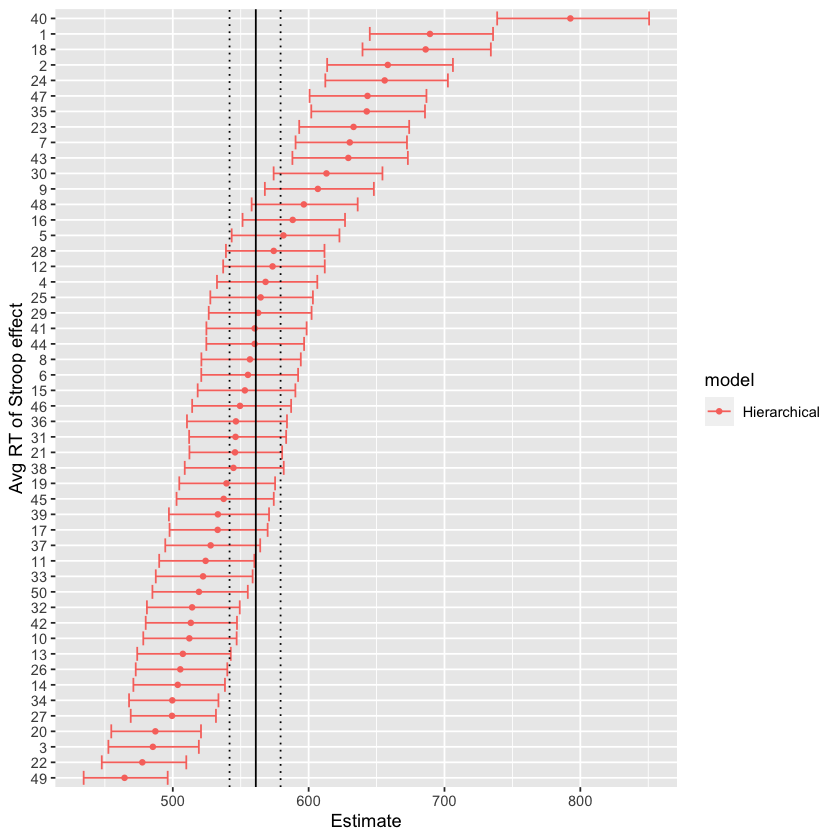

In [61]:
ggplot(
  par_h,
  aes(
    ymin = Q2.5, ymax = Q97.5, x = subj, y = Estimate, color = model,
    shape = model
  )
) +
  geom_errorbar(position = position_dodge(1)) +
  geom_point(position = position_dodge(1)) +
  # We'll also add the mean and 95% CrI of the overall difference
  # to the plot:
  geom_hline(
    yintercept =
      mean(exp(alpha))
  ) +
  geom_hline(
    yintercept =
      quantile(exp(alpha), .025),
    linetype = "dotted", size = .5
  ) +
  geom_hline(
    yintercept =
      quantile(exp(alpha), .975),
    linetype = "dotted", size = .5
  ) +
  xlab("Avg RT of Stroop effect") +
  coord_flip()

## 11.4

### Distributional regression model of the effect of cloze probability on the N400

In section 5.2.6, we saw how to fit a distributional regression model. We might want to extend this approach to Stan. Fit the EEG data to a hierarchical model with by-subject and by-items varying intercept and slopes, and in addition assume that the variance component of the model can vary by subject.



### Base model

In [110]:
# model to compare

fit_eeg_sub_item_uc <- stan("stan_models/n400_hierarchical_corr_IS_item_uc.stan", data = ls_eeg)

In [111]:
yrep_base = extract(fit_eeg_sub_item_uc)$p_size_pred

In [120]:
dev.off()


quartz_off_screen 
                2

In [121]:
dev.new()

In [123]:
theme_ap(family="")

ERROR: Error in theme_ap(family = ""): nie udalo sie znale'z'c funkcji 'theme_ap'


: 

In [122]:
# options(repr.plot.width = 15, repr.plot.height = 15)

pp_check(df_eeg$n400,
  yrep_base,
  fun = "stat_grouped",
  group = df_eeg$subj,
  stat = "sd"
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



ERROR: Error in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, : nie znaleziono krawedzi wielokata


plot without title

### Distributional model

In [63]:
# center variable item
df_eeg <- df_eeg %>%
  mutate(
    item = as.numeric(as.factor(item)),
    c_cloze = cloze - mean(cloze))
    

In [64]:
head(df_eeg)

subj,cloze,item,n400,cloze_ans,N,c_cloze
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,1,7.08,0,44,-0.4760915
1,0.03,2,-0.68,1,44,-0.4460915
1,1.00,3,1.39,44,44,0.5239085
1,0.93,4,22.78,41,44,0.4539085
1,0.00,5,1.61,0,44,-0.4760915
1,0.00,6,3.01,0,44,-0.4760915


In [65]:
# create data for Stan model
ls_eeg <- list(
  N = nrow(df_eeg),
  signal = df_eeg$n400,
  c_cloze = df_eeg$c_cloze,
  subj = df_eeg$subj,
  item = df_eeg$item,
  N_subj = max(df_eeg$subj),
  N_item = max(df_eeg$item))

In [81]:
fit_eeg_dist <- stan("stan_models/n400_distributional.stan", data = ls_eeg)

In [89]:
fit_eeg_dist_check <- stan("stan_models/n400_distributional.stan", data = ls_eeg)

In [83]:
print(fit_eeg_dist,
  pars = c("alpha", "beta", "tau_u", "tau_w", "rho_u", "rho_w", "alpha_sigma", "tau_u_sigma"))

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha           3.69    0.01 0.48  2.74  3.37  3.70  4.02  4.62  2586 1.00
beta            2.26    0.01 0.66  0.96  1.84  2.27  2.70  3.53  5003 1.00
tau_u[1]        2.21    0.01 0.36  1.57  1.95  2.19  2.43  3.00  1706 1.00
tau_u[2]        1.45    0.03 0.87  0.07  0.77  1.39  2.04  3.29  1173 1.00
tau_w[1]        1.78    0.01 0.32  1.16  1.56  1.77  1.99  2.41  1709 1.00
tau_w[2]        1.82    0.03 0.97  0.13  1.10  1.80  2.49  3.75   989 1.01
rho_u[1,1]      1.00     NaN 0.00  1.00  1.00  1.00  1.00  1.00   NaN  NaN
rho_u[1,2]      0.18    0.01 0.35 -0.58 -0.05  0.20  0.44  0.78  4767 1.00
rho_u[2,1]      0.18    0.01 0.35 -0.58 -0.05  0.20  0.44  0.78  4767 1.00
rho_u[2,2]      1.00    0.00 0.00  1.00  1.00  1.00  1.00  1.00  3637 1.00
rho_w[1,1]      1.0

#### Predictive checks

In [95]:
yrep = extract(fit_eeg_dist_check)$p_size_pred

[1] 11452000

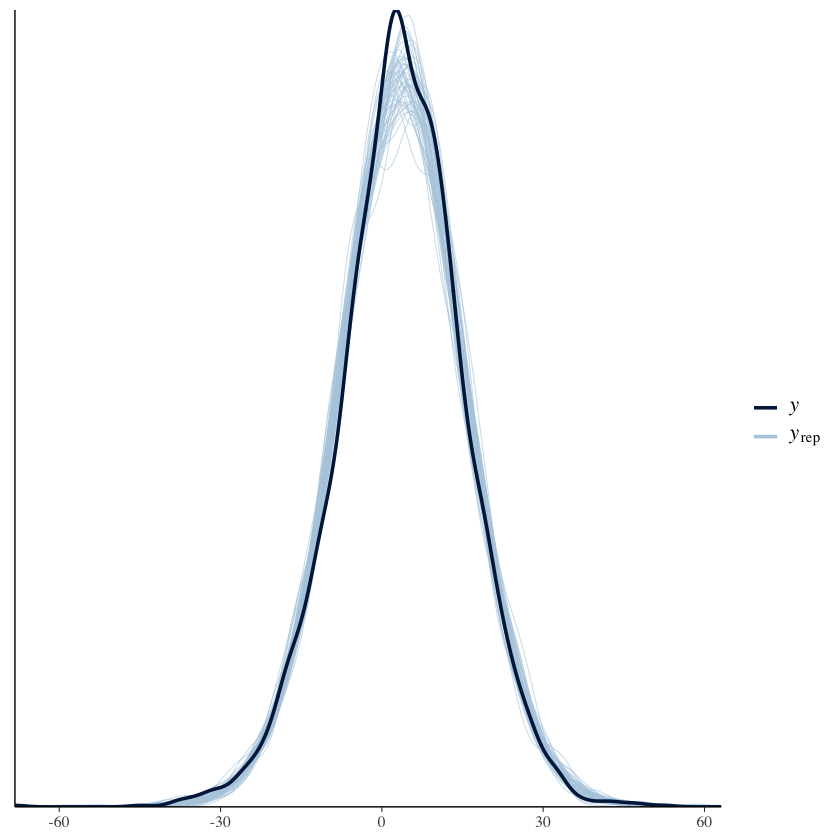

In [96]:
ppc_dens_overlay(df_eeg$n400, yrep = yrep[1:50, ])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



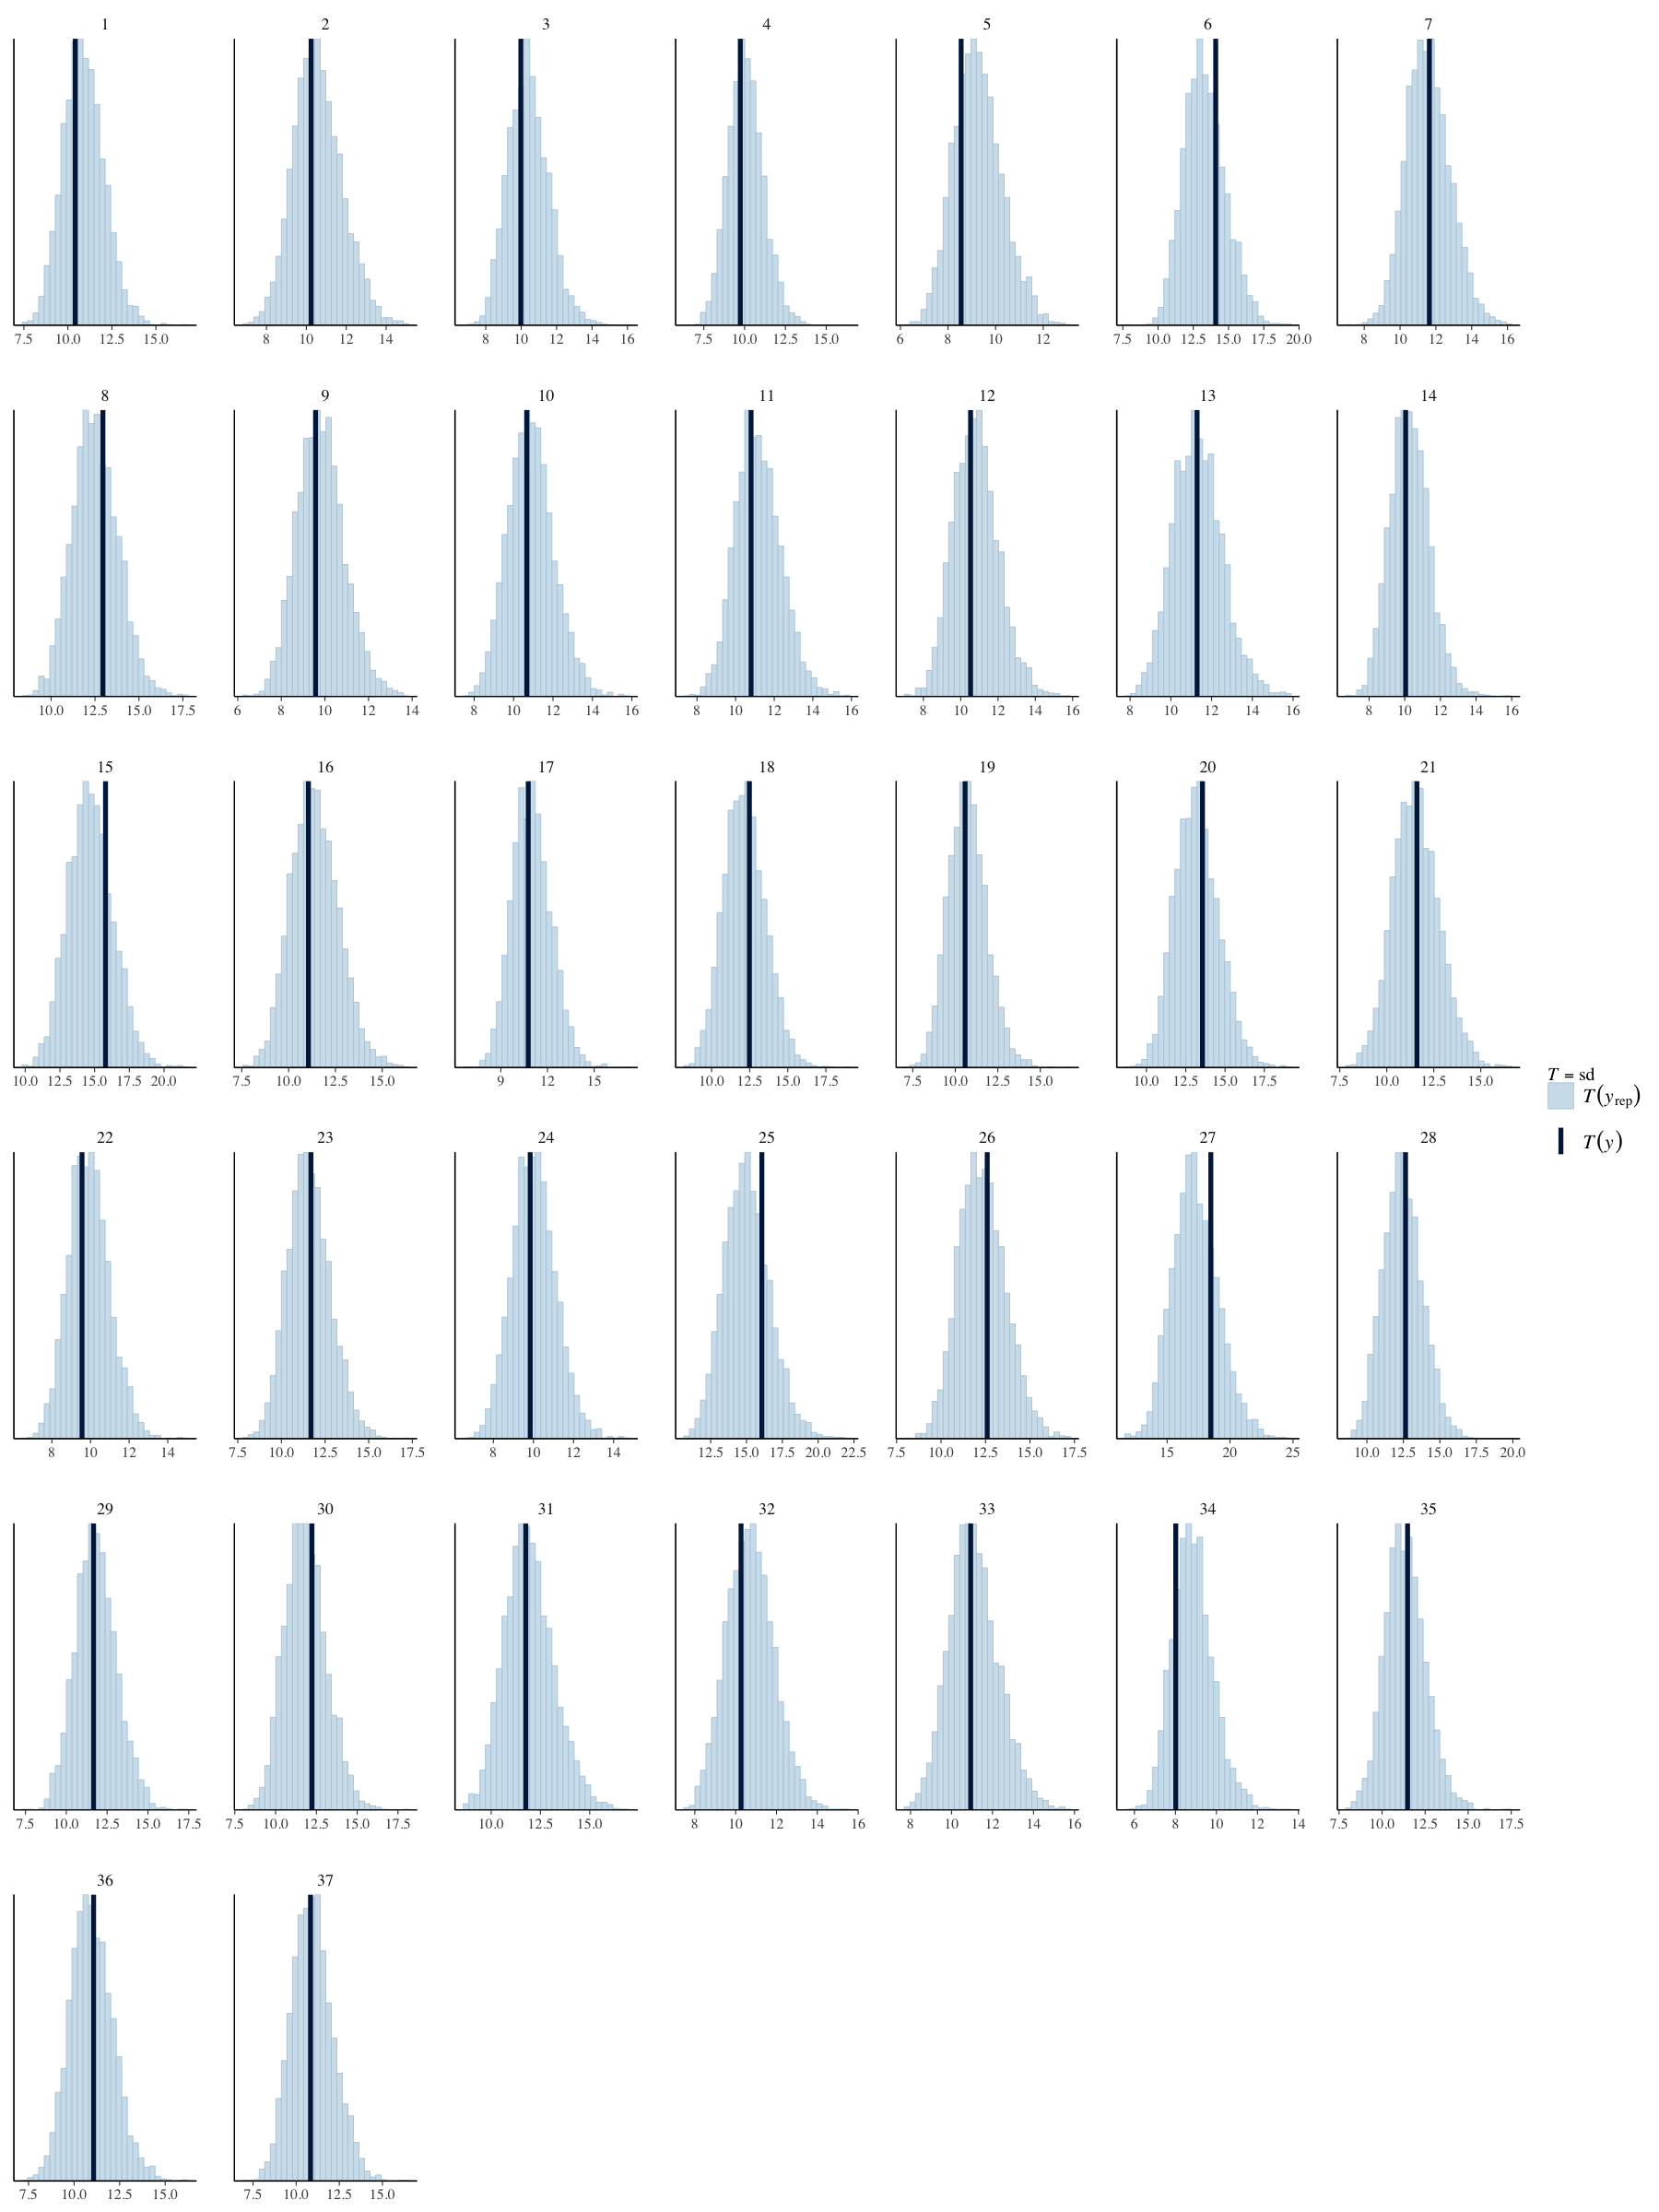

In [104]:
options(repr.plot.width = 15, repr.plot.height = 20)

pp_check(df_eeg$n400,
  yrep,
  fun = "stat_grouped",
  group = df_eeg$subj,
  stat = "sd"
)